In [46]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import linear_kernel
from sklearn import metrics

In [2]:
import pandas as pd

df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/evaluation.csv')

In [3]:
df_train

,text,reason,label
0,this is an amazing app for online classes!but,good app for conducting online classes,1
1,very practical and easy to use,app is user-friendly,1
2,this app is very good for video conferencing.,good for video conferencing,1
3,i can not download this zoom app,unable to download zoom app,1
4,i am not able to download this app,want to download the app,1
...,...,...,...
2056,i am not getting jio tv properly.,unable to use with jio tv,1
2057,(learn from the netflix interface),netflix ui is better,1
2058,"hello,\ndisney+ must also be installed on chro...",unable to use disney on chromecast,1
2059,it is a shame that disney+ does not work on tv...,unable to use disney plus on tv,1


In [122]:
df_test

,text,reason,label
0,the app is crashing when i play a vedio,app crashes during playback,1
1,but i want to connect it to the tv from one de...,want compatibility with more smart televisions,0
2,very helpful when and home working remotley,good app for work,0
3,this zoom so called and missed call and mobile...,receiving incorrect phone number message,0
4,one of my favorite apps,good for spending time,0
...,...,...,...
8995,very good streaming platform has a lot of content,app has very good content,1
8996,so paying for an app that is not fit for purpose.,unable to use app,0
8997,"it does not work well for me, it loads, but if...",app keeps loading indefinitely,0
8998,i can not watch the new disney shows.,unable to load the episodes list,0


In [124]:
from sklearn.utils import resample

In [127]:
def upsample_data(df_test):
    # separate minority and majority classes
    negative = df_test[df_test.label==0]
    positive = df_test[df_test.label==1]
    # upsample minority
    pos_upsampled = resample(positive,
     replace=True, # sample with replacement
     n_samples=len(negative), # match number in majority class
     random_state=27) # reproducible results
    # combine majority and upsampled minority
    upsampled = pd.concat([negative, pos_upsampled])
    # check new class counts
    print('new distr:', upsampled.label.value_counts())
    
    return upsampled

In [128]:
# make up tf-idf encoder
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = df_train['text'].to_list() + df_train['reason'].to_list()
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)

TfidfVectorizer()

In [137]:
def evaluate(df_train, thresholds=[0.2], name="train", plot_distr=False, metric_fn=None, reverse=False):
    if name=='test':
        df_train = upsample_data(df_train)
    
    x1 = vectorizer.transform(df_train['text'])
    x2 = vectorizer.transform(df_train['reason'])

    y = np.array(df_train['label'].to_list())
    
    if reverse:
        cos_mat = 1 - metric_fn(x1, x2)
    else:
        cos_mat = metric_fn(x1, x2)

    # The diagonal elements correspond to label 1 (in train set) and non diagonal ones to label 0
    cos_mat_diags = cos_mat.diagonal()
    cos_mat_non_diags = np.array([cos_mat[i][j] for i in range(size) for j in range(size) if i!=j])
    cos_mat_non_diags = np.random.choice(cos_mat_non_diags, cos_mat_diags.shape[0])
    # print('mean of cos_mat_diags:', cos_mat_diags.mean())
    # print('mean of cos_mat_non_diags:', cos_mat_non_diags.mean())

    if plot_distr:
        # check the distribution of diagonal elements
        sns.set_style('whitegrid')
        sns.kdeplot(np.array(cos_mat_diags), bw_method=0.5)
        plt.title('Score distribution of diagonal samples')
        plt.show()

        # sns.set_style('whitegrid')
        # sns.kdeplot(cos_mat_non_diags, bw_method=0.5)
        # plt.title('Score distribution of actually negative samples')
        # plt.show()

    if name=='test':
        y_pred = cos_mat_diags
        y_true = y
    else:
        y_pred = np.concatenate([cos_mat_diags, cos_mat_non_diags])
        y_true = np.concatenate([y, np.zeros(cos_mat_non_diags.shape[0])])

    fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
    auc = metrics.roc_auc_score(y_true, y_pred)
    plt.plot(fpr, tpr, label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.title('ROC Curve')
    plt.show()
    
    # threshold = 0.1
    for threshold in thresholds:
        y_pred_thresh = np.where(y_pred>threshold, 1, 0)
        print(f'Classification Report for Threshold {threshold} on {name.upper()} set:\n', metrics.classification_report(y_true, y_pred_thresh))

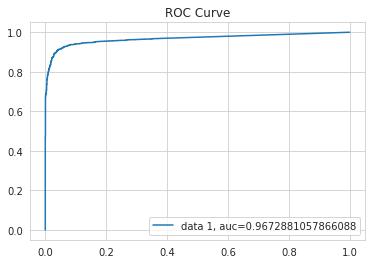

Classification Report for Threshold 0.01 on TRAIN set:
               precision    recall  f1-score   support

         0.0       0.95      0.65      0.77      2061
         1.0       0.73      0.97      0.83      2061

    accuracy                           0.81      4122
   macro avg       0.84      0.81      0.80      4122
weighted avg       0.84      0.81      0.80      4122

Classification Report for Threshold 0.05 on TRAIN set:
               precision    recall  f1-score   support

         0.0       0.94      0.86      0.90      2061
         1.0       0.87      0.95      0.91      2061

    accuracy                           0.90      4122
   macro avg       0.91      0.90      0.90      4122
weighted avg       0.91      0.90      0.90      4122

Classification Report for Threshold 0.07 on TRAIN set:
               precision    recall  f1-score   support

         0.0       0.94      0.90      0.92      2061
         1.0       0.90      0.94      0.92      2061

    accuracy  

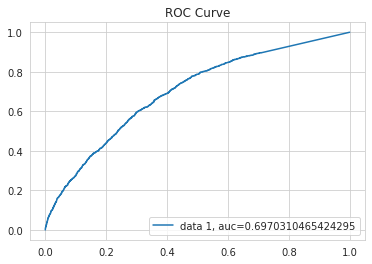

Classification Report for Threshold 0.01 on TEST set:
               precision    recall  f1-score   support

           0       0.74      0.29      0.42      5999
           1       0.56      0.90      0.69      5999

    accuracy                           0.59     11998
   macro avg       0.65      0.59      0.55     11998
weighted avg       0.65      0.59      0.55     11998

Classification Report for Threshold 0.05 on TEST set:
               precision    recall  f1-score   support

           0       0.72      0.43      0.54      5999
           1       0.59      0.83      0.69      5999

    accuracy                           0.63     11998
   macro avg       0.65      0.63      0.62     11998
weighted avg       0.65      0.63      0.62     11998

Classification Report for Threshold 0.07 on TEST set:
               precision    recall  f1-score   support

           0       0.70      0.49      0.58      5999
           1       0.61      0.79      0.69      5999

    accuracy     

In [150]:
thresholds = [0.01, 0.05, 0.07, 0.1, 0.15, 0.2]
metric_fn = metrics.pairwise.linear_kernel

evaluate(df_train, thresholds=thresholds, name="train", metric_fn=metric_fn)
evaluate(df_test, thresholds=thresholds, name="test", metric_fn=metric_fn)

In [114]:
# we see that we get 65% test accuracy at threshold 0.1 
# using linear_kernel metric (practically same as cosine similarity)

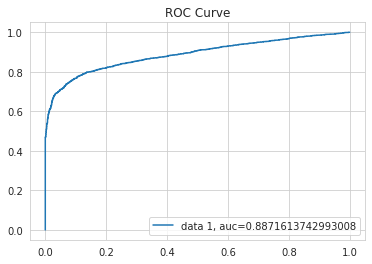

Classification Report for Threshold -5 on TRAIN set:
               precision    recall  f1-score   support

         0.0       0.87      0.10      0.18      2061
         1.0       0.52      0.98      0.68      2061

    accuracy                           0.54      4122
   macro avg       0.70      0.54      0.43      4122
weighted avg       0.70      0.54      0.43      4122

Classification Report for Threshold -4 on TRAIN set:
               precision    recall  f1-score   support

         0.0       0.85      0.43      0.57      2061
         1.0       0.62      0.92      0.74      2061

    accuracy                           0.68      4122
   macro avg       0.73      0.68      0.66      4122
weighted avg       0.73      0.68      0.66      4122

Classification Report for Threshold -3 on TRAIN set:
               precision    recall  f1-score   support

         0.0       0.79      0.92      0.85      2061
         1.0       0.90      0.75      0.82      2061

    accuracy        

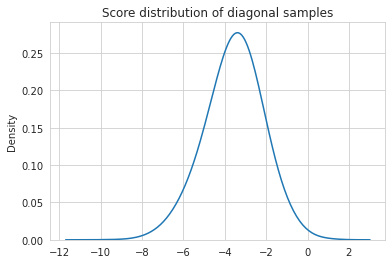

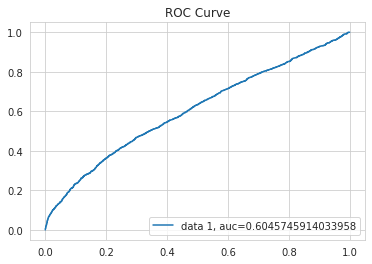

Classification Report for Threshold -5 on TEST set:
               precision    recall  f1-score   support

           0       0.58      0.16      0.25      5999
           1       0.51      0.88      0.65      5999

    accuracy                           0.52     11998
   macro avg       0.55      0.52      0.45     11998
weighted avg       0.55      0.52      0.45     11998

Classification Report for Threshold -4 on TEST set:
               precision    recall  f1-score   support

           0       0.58      0.40      0.47      5999
           1       0.54      0.72      0.62      5999

    accuracy                           0.56     11998
   macro avg       0.56      0.56      0.55     11998
weighted avg       0.56      0.56      0.55     11998

Classification Report for Threshold -3 on TEST set:
               precision    recall  f1-score   support

           0       0.56      0.73      0.64      5999
           1       0.62      0.43      0.51      5999

    accuracy           

In [147]:
thresholds = [-5, -4, -3, -2]
metric_fn = metrics.pairwise.manhattan_distances

evaluate(df_train, thresholds=thresholds, name="train", metric_fn=metric_fn, reverse=True)
evaluate(df_test, thresholds=thresholds, name="test", metric_fn=metric_fn, reverse=True, plot_distr=True)

In [111]:
# as we see, manhattan distance is not giving better results